In [4]:
from importlib import reload

import torch
import numpy as np
import sciplots as plots
from scipy import stats
from sklearn.decomposition import PCA
from matplotlib.collections import FillBetweenPolyCollection

from src import main
from src.utils import data
from src.utils.utils import open_config

reload(plots.clustering)
reload(data)
reload(main)
import sciplots as plots
from src.main import init

In [9]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0049E0', '#0090E0', '#00D7E0', '#2CDEE6', '#00E09E', '#00E051'][:-2]
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#01FB3D', '#00FA8F', '#89FA00']
flamingo_colours = ['#FA2100', '#FABD00', '#FA7700']
flamingo_test = ['#FA07A0']
colours = ['k'] + flamingo_colours[2:] + bahamas_agn_colours + bahamas_colours

In [6]:
known = [
    'flamingo',
    # 'flamingo_low',
    # 'flamingo_hi',
    'bahamas_cdm',
    'bahamas_cdm_low',
    'bahamas_cdm_hi',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
]
# unknown = ['bahamas_dmo_cdm', 'bahamas_dmo_0.1', 'bahamas_dmo_1', 'noise']
unknown = ['flamingo_low_test']

loaders, net, dataset = init(known, config, unknown=unknown)
print(net)

data = net.predict(loaders[1])
# data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
data['targets'] = data['targets'].squeeze()
labels = dataset.names[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)]


Training data size: 25280	Validation data size: 6320
Architecture: CompactClusterEncoder
Description: FLAMINGO, FLAMINGO test unknown, 
Network: network_v8
Epoch: 200
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (method: mean, center_step: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 0.2, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)
Prediction time: 1.904e+00 s


In [7]:
data['latent'][:, 0] *= 1e6
pca = PCA(n_components=4).fit(data['latent'][np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
# pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
pca_transform[:, 0] /= 1e6
data['latent'][:, 0] /= 1e6

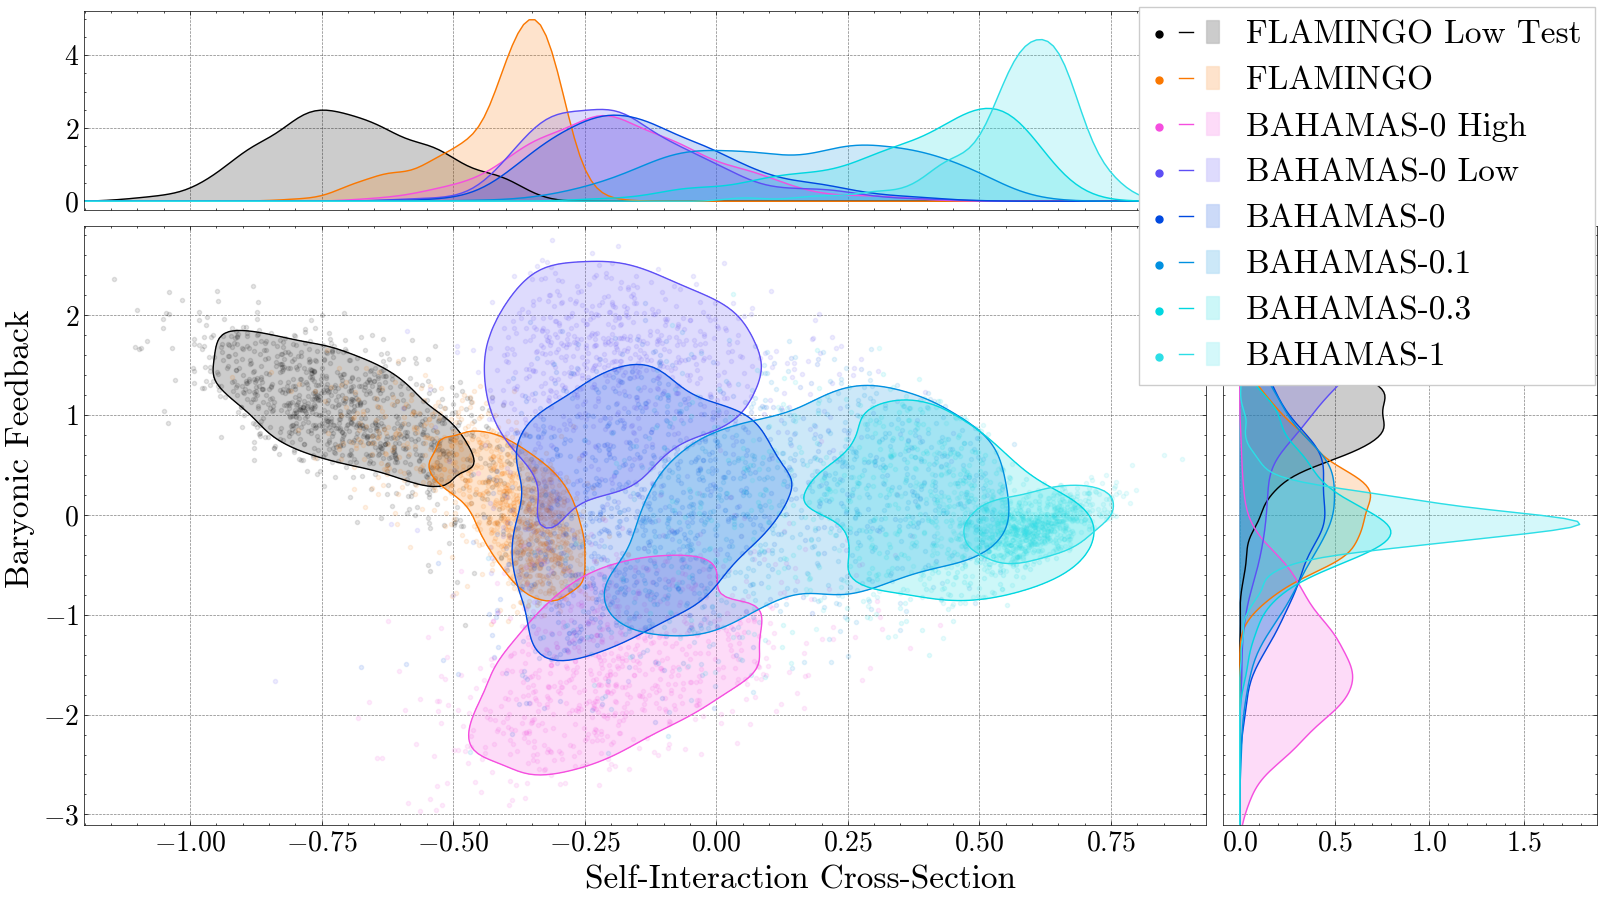

In [10]:
plot = plots.PlotClusters(
    pca_transform[:, [0, 2]],
    data['targets'],
    # norm=True,
    density=True,
    x_label='Self-Interaction Cross-Section',
    y_label='Baryonic Feedback',
    labels=labels,
    colours=colours,
    alpha=0.1,
    alpha_2d=0.2,
    # rows=int(len(labels) / 2),
    rows=len(labels),
    loc='upper right',
)

In [93]:
plot.savefig('../plots/', name='test_pca2_bahamas_agn_flamingo')

In [11]:
def cluster_loss(latent, labels, cluster_class):
    centers = []

    for label in np.unique(labels):
        idxs = label == labels
        centers.append(np.mean(latent[idxs], axis=0))

    centers = np.stack(centers)

    idxs = np.unique(labels) == cluster_class
    class_vecs = latent[labels == cluster_class] - centers[idxs]

    # Direction to the other classes
    direcs = centers[~idxs] - centers[idxs]

    # Projected vectors for the target class in the direction of the other classes
    proj_vecs = class_vecs @ direcs.T / np.linalg.norm(direcs, axis=-1)

    # Average scatter in the direction of the other classes
    return proj_vecs, np.linalg.norm(direcs, axis=-1) / np.std(proj_vecs, axis=0)

In [12]:
idx = 0
_, stds = cluster_loss(data['latent'], data['targets'], np.unique(data['targets'])[idx])
print(f"Target Sim: {labels[idx]}\n{'\n'.join([f'Sim: {sim:<15}\tSTD: {std:.2f}' for sim, std in zip([label for label in labels if label != labels[idx]], stds)])}")

Target Sim: FLAMINGO Low Test
Sim: FLAMINGO       	STD: 2.29
Sim: BAHAMAS-0 High 	STD: 17.17
Sim: BAHAMAS-0 Low  	STD: 17.28
Sim: BAHAMAS-0      	STD: 28.91
Sim: BAHAMAS-0.1    	STD: 21.14
Sim: BAHAMAS-0.3    	STD: 12.89
Sim: BAHAMAS-1      	STD: 9.71


Target Sim: FLAMINGO Low Test
Sim: FLAMINGO       	Distance: 1.49
Sim: BAHAMAS-0 High 	Distance: 4.35
Sim: BAHAMAS-0 Low  	Distance: 3.46
Sim: BAHAMAS-0      	Distance: 3.90
Sim: BAHAMAS-0.1    	Distance: 3.96
Sim: BAHAMAS-0.3    	Distance: 3.98
Sim: BAHAMAS-1      	Distance: 4.14


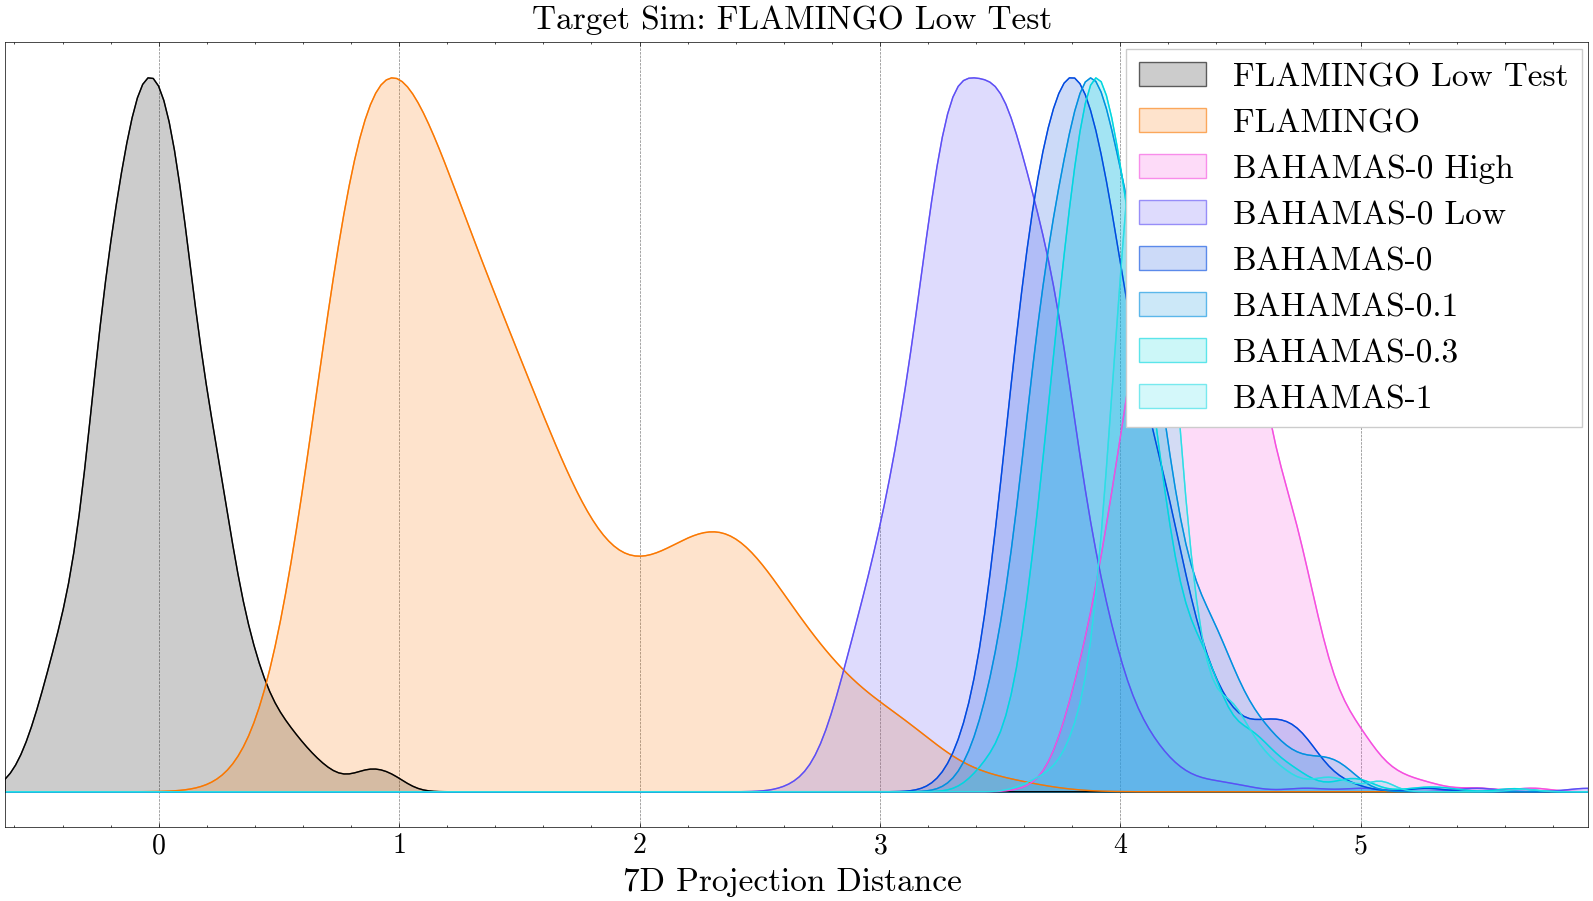

In [16]:
idx = 0
cluster_class = np.unique(data['targets'])[idx]
proj_vecs = []
centers = []
vecs = []

for target in np.unique(data['targets']):
    idxs = target == data['targets']
    centers.append(np.mean(data['latent'][idxs], axis=0))
    vecs.append(data['latent'][idxs] - centers[-1])

centers = np.stack(centers)
vecs = np.array(vecs, dtype=object)

idxs = np.unique(data['targets']) == cluster_class
class_vecs = data['latent'][data['targets'] == cluster_class] - centers[idxs]
relative_class_vecs = data['latent'][data['targets'] == cluster_class][..., np.newaxis] - centers[~idxs].T[np.newaxis]

# Direction to the other classes
direcs = centers[~idxs] - centers[idxs]

for vec in vecs[idxs]:
    proj_vecs.append(vec @ direcs.T / np.linalg.norm(direcs, axis=-1))

for i, vec in enumerate(vecs[~idxs]):
    proj_vecs.append(np.linalg.norm(direcs[i]) - vec @ direcs[i] / np.linalg.norm(direcs[i]))

print(f"Target Sim: {labels[idx]}\n{'\n'.join(
    [f"Sim: {sim:<15}\tDistance: {stats.wasserstein_distance(
        test_vecs,
        target_vecs
    ):.2f}" for sim, test_vecs, target_vecs in zip([label for label in labels if label != labels[idx]], proj_vecs[0].swapaxes(0, 1), proj_vecs[1:])])}")

plot = plots.PlotDistribution(
    # [*proj_vecs[0].swapaxes(0, 1), *proj_vecs[1:]],
    [proj_vecs[0].swapaxes(0, 1)[1], *proj_vecs[1:]],
    # proj_vecs[1:],
    density=True,
    norm=True,
    bins=300,
    x_label='7D Projection Distance',
    # colours=colours[1:] * 2,
    colours=colours,
    # labels=[label for label in labels if label != labels[idx]],
    labels=labels,
    axis=True,
    rows=len(labels),
    alpha_2d=0.2,
    # loc=(0.3, 0.55),
    loc='upper right',
    title=f'Target Sim: {labels[idx]}'
)
plot.axes.set_xlim([min(0, np.min(proj_vecs[0][:, 1])), max([np.max(proj_vec) for proj_vec in proj_vecs[1:]])])
plot.axes.set_yticks([])
plot.plots = [plot for plot in plot.plots if isinstance(plot, FillBetweenPolyCollection)]
plot.plots = plot.plots[:len(labels)]
plot.create_legend(**plot._legend_kwargs)

In [17]:
plot.savefig('../plots/', name='test')

In [223]:
range_ = (min(np.min(proj_vecs[0][:, 0]), np.min(proj_vecs[1])), max(np.max(proj_vecs[0][:, 0]), np.max(proj_vecs[1])))
# range_ = (np.min(proj_vecs[0][:, 0]), np.max(proj_vecs[0][:, 0]))
grid = np.mgrid[range_[0]:range_[1]:200j]
test_kernel = stats.gaussian_kde(proj_vecs[0][:, 0])
target_kernel = stats.gaussian_kde(proj_vecs[1])
test_pdf = test_kernel.pdf(grid)
target_pdf = target_kernel.pdf(grid)
# target_pdf = target_kernel.pdf()

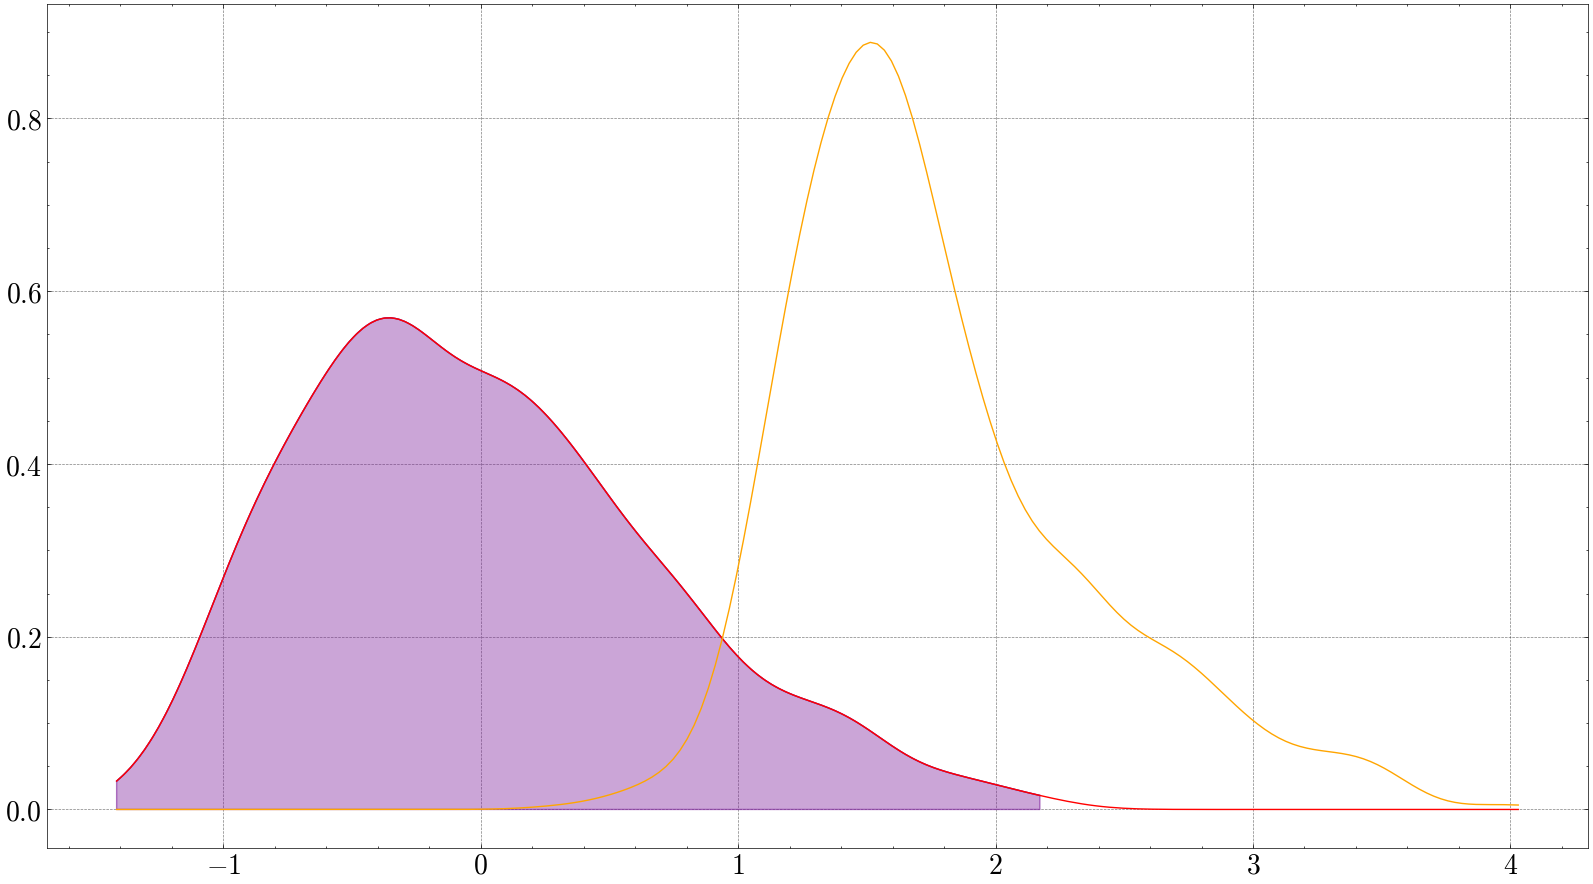

In [224]:
plot = plots.PlotDistribution(proj_vecs[0][:, 0], density=True, bins=200)
plot.axes.plot(grid, test_pdf, color='r')
plot.axes.plot(grid, target_pdf, color='orange')

In [225]:
# samples = test_kernel.resample(size=int(1e4))[0]
test_pdf = test_kernel.pdf(proj_vecs[0][:, 0])
target_pdf = target_kernel.pdf(proj_vecs[0][:, 0])
# torch.nn.functional.kl_div(torch.from_numpy(target_pdf).log(), torch.from_numpy(test_pdf))
np.mean(target_pdf * np.log(target_pdf / test_pdf))

np.float64(0.10677757033556624)

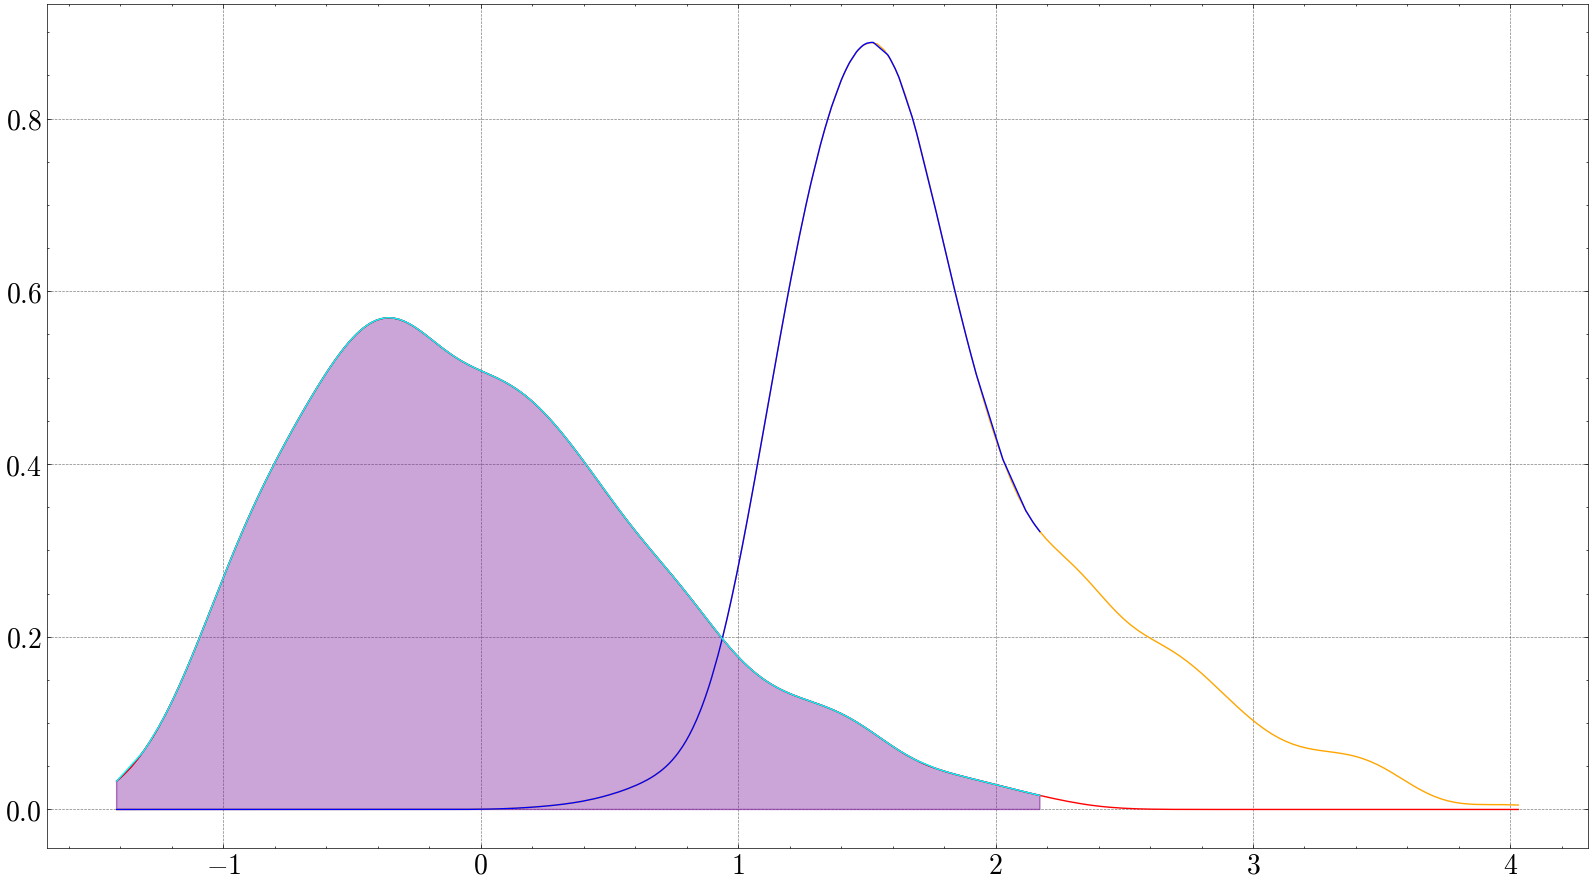

In [226]:
idxs = np.argsort(proj_vecs[0][:, 0])
plot.axes.plot(proj_vecs[0][idxs, 0], target_pdf[idxs], color='blue')
plot.axes.plot(proj_vecs[0][idxs, 0], test_pdf[idxs], color='cyan')
plot.fig